In [ ]:
import torch
from torch import nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, cin, cout, ct, cmid=None):
        super().__init__()

        if cmid is None: cmid = cout

        self.layer = nn.Sequential(
            nn.Conv2d(cin, cmid, 3, 1, 1),
            nn.GroupNorm(1, cmid), # layer norm for 2d image
            nn.GELU(),
            nn.Conv2d(cmid, cout, 3, 1, 1),
            nn.GroupNorm(1, cout),
            nn.GELU()
        )
        self.time_embed = nn.Linear(ct, cin)

    def forward(self, x, t):
        """
        :param x: [batch, cin, n, n]
        :param t: [batch, ct]
        :return: [batch. cout, n, n]
        """
        t = self.time_embed(t)
        return self.layer(x + t[:, :, None, None])

class DownSample(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(cin, cout, 2, 2, 0),
            nn.GELU(),
            nn.Conv2d(cout, cout, 3, 1, 1),
            nn.GELU()
        )

    def forward(self, x):
        return self.layer(x)

class UpSample(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(cin, cout, 2, 2, 0),
            nn.GELU(),
            nn.Conv2d(cout, cout, 3, 1, 1),
            nn.GELU()
        )

    def forward(self, x):
        return self.layer(x)

class UNet(nn.Module):
    def __init__(self, cin=3, cout=3, time_dim=128, device='cpu'):
        super().__init__()
        self.scale = 2
        self.time_dim = time_dim
        self.device = device

        self.income = nn.Sequential(
            nn.Conv2d(cin, 16*self.scale, 3, 1, 1),
            nn.GELU(),
            nn.Conv2d(16*self.scale, 16*self.scale, 3, 1, 1),
            nn.GELU()
        )

        self.dc1_l = DoubleConv(cin=16*self.scale, cout=32*self.scale, ct=time_dim)

        self.down1 = DownSample(cin=32*self.scale, cout=32*self.scale)
        self.dc2_l = DoubleConv(cin=32*self.scale, cout=64*self.scale, ct=time_dim)

        self.down2 = DownSample(cin=64*self.scale, cout=64*self.scale)
        self.dc3_l = DoubleConv(cin=64*self.scale, cout=128*self.scale, ct=time_dim)

        self.down3 = DownSample(cin=128*self.scale, cout=128*self.scale)
        self.bottom = DoubleConv(cin=128*self.scale, cout=128*self.scale, ct=time_dim, cmid=256*self.scale)

        self.up3 = UpSample(cin=128*self.scale, cout=128*self.scale)
        self.dc3_r = DoubleConv(cin=256*self.scale, cout=64*self.scale, ct=time_dim, cmid=128*self.scale)

        self.up2 = UpSample(cin=64*self.scale, cout=64*self.scale)
        self.dc2_r = DoubleConv(cin=128*self.scale, cout=32*self.scale, ct=time_dim, cmid=64*self.scale)

        self.up1 = UpSample(cin=32*self.scale, cout=32*self.scale)
        self.dc1_r = DoubleConv(cin=64*self.scale, cout=16*self.scale, ct=time_dim, cmid=32*self.scale)

        self.outcome = nn.Sequential(
            nn.Conv2d(16*self.scale, 16*self.scale, 3, 1, 1),
            nn.GELU(),
            nn.Conv2d(16*self.scale, cout, 3, 1, 1)
        )

        self.to(device)


    def position_encoding(self, t, channels):
        inv_freq = 1.0 / (
                10000
                ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        """
        :param x: [batch, cin, n, n]
        :param t: [batch,]
        :return: [batch, cout, n, n]
        """
        t = t[:,None].to(torch.float)
        t = self.position_encoding(t, self.time_dim) # [batch, t_dim]

        x1 = self.income(x) # [batch, 16, n, n]
        x1 = self.dc1_l(x1, t) # [batch, 32, n, n]

        x2 = self.down1(x1) # [batch, 32, n/2, n/2]
        x2 = self.dc2_l(x2, t) # [batch, 64, n/2, n/2]

        x3 = self.down2(x2) # [batch, 64, n/4, n/4]
        x3 = self.dc3_l(x3, t) # [batch, 128, n/4, n/4]

        x4 = self.down3(x3) # [batch, 128, n/8, n/8]
        x4 =  self.bottom(x4, t) # [batch, 128, n/8, n/8]

        x5 = self.up3(x4) # [batch, 128, n/4, n/4]
        x5 = torch.cat([x3, x5], dim=1) # [batch, 256, n/4, n/4]
        x5 = self.dc3_r(x5, t) # [batch, 64, n/4, n/4]

        x6 = self.up2(x5) # [batch, 64, n/2, n/2]
        x6 = torch.cat([x2, x6], dim=1) # [batch, 128, n/2, n/2]
        x6 = self.dc2_r(x6, t) # [batch, 32, n/2, n/2]

        x7 = self.up1(x6) # [batch, 32, n, n]
        x7 = torch.cat([x1, x7], dim=1) # [batch, 64, n, n]
        x7 = self.dc1_r(x7, t) # [batch, 16, n, n]

        out = self.outcome(x7) # [batch, 3, n, n]
        return out




In [ ]:
x = torch.randn(8, 3, 64, 64)
t = torch.randint(low=0, high=10, size=[8,])
net = UNet(cin=3, cout=3, time_dim=256, device='cpu')
out = net(x, t)
print(out.shape)

torch.Size([8, 3, 64, 64])


In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class Diffusion:
    def __init__(self,
                 steps=1000,
                 beta_start=1e-4,
                 beta_end=0.02,
                 img_size=32,
                 img_c=3,
                 t_dim=256,
                 device='cpu'):
        self.device = device
        self.unet = UNet(cin=img_c, cout=img_c, time_dim=t_dim, device=device)
        self.steps = steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.img_c = img_c

        self.beta = torch.linspace(beta_start, beta_end, steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

        # variances for q(x[t-1] | x[t], x[0])
        self.vars = (1 - self.alpha[1:]) * (1 - self.alpha_bar[:-1]) / (1 - self.alpha_bar[1:])
        self.vars = torch.cat([
            torch.zeros([1,]).to(device), self.vars
        ])

        self.preprocess = transforms.Compose([
            transforms.ToTensor()
        ])

    def noisy_image(self, x, t):
        """
        :param x: [batch, cin, n, n]
        :param t: [batch,]
        :return
            noisy image
            noise
        """
        ab = self.alpha_bar[t-1][:, None, None, None]
        eps = torch.randn_like(x).to(device=self.device)
        return torch.sqrt(ab) * x + torch.sqrt(1-ab) * eps, eps

    @torch.no_grad()
    def sample(self, return_sequence=False):
        x = torch.randn(1, self.img_c, self.img_size, self.img_size).to(self.device)
        sequence = []
        for i in reversed(range(0, self.steps)):
            sequence.append(x.clone())
            t = torch.ones([1]).to(self.device) * i
            noise_pred = self.unet(x, t)

            a = self.alpha[i]
            ab = self.alpha_bar[i]

            x = 1/torch.sqrt(a) * x - (1-a)/torch.sqrt(a*(1-ab)) * noise_pred + torch.sqrt(self.vars[i]) * torch.randn_like(x).to(self.device)
        x = x.detach().cpu().numpy()
        x = (x.clip(-1, 1) + 1) / 2
        sequence.append(x.clone())
        if return_sequence:
            return sequence
        else:
            return x

    def train(self, ds, batch_size=8, lr=1e-3, epochs=200):
        dl = DataLoader(ds, batch_size=batch_size, shuffle=True)
        optimizer = torch.optim.Adam(self.unet.parameters(), lr=lr)
        criterion = nn.MSELoss()
        num_iter = 0
        ckpt = torch.load('./drive/MyDrive/diffusion2/430.pth')
        self.unet.load_state_dict(ckpt)

        self.unet.train()
        for e in range(430, 430+epochs):
            for i, (x, _) in enumerate(dl):
                num_iter += 1
                # print(x.shape)

                x = x.to(self.device) * 2 - 1
                t = torch.randint(low=1, high=self.steps+1, size=(len(x),)).to(self.device)
                noisy_img, noise = self.noisy_image(x, t)
                optimizer.zero_grad()
                pred = self.unet(noisy_img, t)
                loss = criterion(pred, noise)
                loss.backward()
                optimizer.step()

                if num_iter % 250 == 0:
                    print(f'Epoch {e + 1}, Batch {i + 1}/{len(dl)}, Loss: {loss.item()}')
                if num_iter % 2000 == 0:
                    self.unet.eval()
                    img = self.sample()
                    img = img.transpose(0, 2, 3, 1)
                    img = (img[0] * 255).astype(int)
                    plt.imshow(img)
                    plt.show()
                    self.unet.train()

            if e % 10 == 0:
                torch.save(self.unet.state_dict(), './drive/MyDrive/diffusion2/%d.pth'%e)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=2bb7e8a7-3f08-4ef2-946b-4619ede08127
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:25<00:00, 57.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/data/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 186MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/data/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 37.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/data/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 24.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /content/data/celeba/list_landma

Epoch 431, Batch 250/2544, Loss: 0.015574566088616848
Epoch 431, Batch 500/2544, Loss: 0.012845315039157867
Epoch 431, Batch 750/2544, Loss: 0.013064033351838589
Epoch 431, Batch 1000/2544, Loss: 0.013916730880737305
Epoch 431, Batch 1250/2544, Loss: 0.016146361827850342
Epoch 431, Batch 1500/2544, Loss: 0.017241233959794044
Epoch 431, Batch 1750/2544, Loss: 0.009844649583101273
Epoch 431, Batch 2000/2544, Loss: 0.010824749246239662


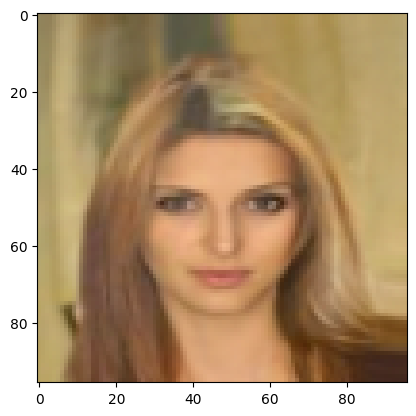

Epoch 431, Batch 2250/2544, Loss: 0.012769066728651524
Epoch 431, Batch 2500/2544, Loss: 0.016156217083334923
Epoch 432, Batch 206/2544, Loss: 0.016578959301114082
Epoch 432, Batch 456/2544, Loss: 0.009759627282619476
Epoch 432, Batch 706/2544, Loss: 0.009349045343697071
Epoch 432, Batch 956/2544, Loss: 0.01345574576407671
Epoch 432, Batch 1206/2544, Loss: 0.01088414154946804
Epoch 432, Batch 1456/2544, Loss: 0.009428433142602444


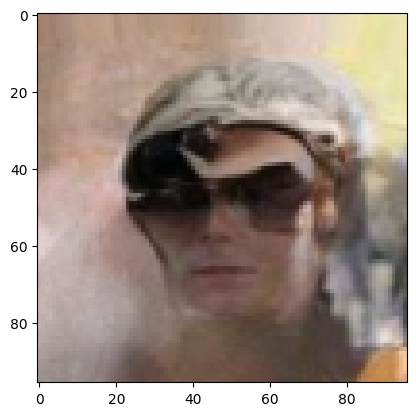

Epoch 432, Batch 1706/2544, Loss: 0.023833390325307846
Epoch 432, Batch 1956/2544, Loss: 0.00680779991671443
Epoch 432, Batch 2206/2544, Loss: 0.012877015396952629
Epoch 432, Batch 2456/2544, Loss: 0.017513908445835114
Epoch 433, Batch 162/2544, Loss: 0.007213560398668051
Epoch 433, Batch 412/2544, Loss: 0.012965579517185688
Epoch 433, Batch 662/2544, Loss: 0.02024386078119278
Epoch 433, Batch 912/2544, Loss: 0.014845293946564198


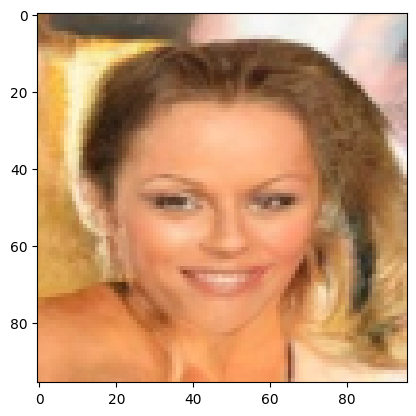

Epoch 433, Batch 1162/2544, Loss: 0.009541206993162632
Epoch 433, Batch 1412/2544, Loss: 0.018452132120728493
Epoch 433, Batch 1662/2544, Loss: 0.010508553124964237
Epoch 433, Batch 1912/2544, Loss: 0.011416095308959484
Epoch 433, Batch 2162/2544, Loss: 0.004364051390439272
Epoch 433, Batch 2412/2544, Loss: 0.013375763781368732
Epoch 434, Batch 118/2544, Loss: 0.011214370839297771
Epoch 434, Batch 368/2544, Loss: 0.013546804897487164


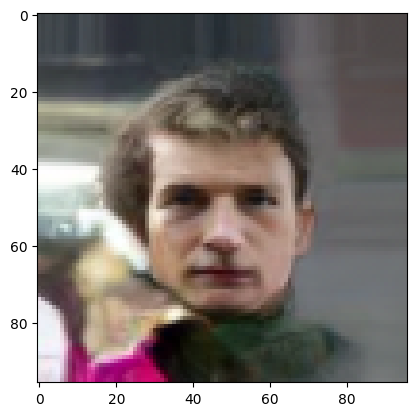

Epoch 434, Batch 618/2544, Loss: 0.011113793589174747
Epoch 434, Batch 868/2544, Loss: 0.011659759096801281
Epoch 434, Batch 1118/2544, Loss: 0.014259206131100655
Epoch 434, Batch 1368/2544, Loss: 0.016062721610069275
Epoch 434, Batch 1618/2544, Loss: 0.013420374132692814
Epoch 434, Batch 1868/2544, Loss: 0.009576437994837761
Epoch 434, Batch 2118/2544, Loss: 0.011940437369048595
Epoch 434, Batch 2368/2544, Loss: 0.009025703184306622


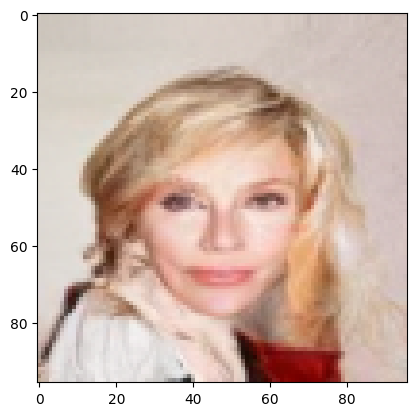

Epoch 435, Batch 74/2544, Loss: 0.00794390868395567
Epoch 435, Batch 324/2544, Loss: 0.008505570702254772
Epoch 435, Batch 574/2544, Loss: 0.015633657574653625
Epoch 435, Batch 824/2544, Loss: 0.009329359047114849
Epoch 435, Batch 1074/2544, Loss: 0.014760874211788177
Epoch 435, Batch 1324/2544, Loss: 0.011042148806154728
Epoch 435, Batch 1574/2544, Loss: 0.02128298580646515
Epoch 435, Batch 1824/2544, Loss: 0.007151844445616007


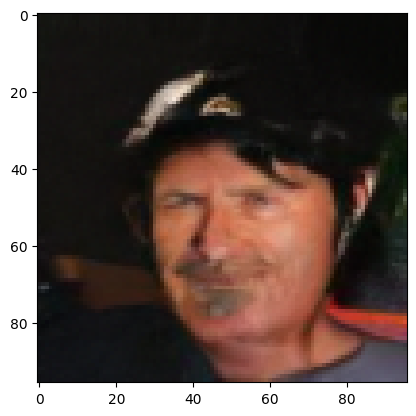

Epoch 435, Batch 2074/2544, Loss: 0.01234001386910677
Epoch 435, Batch 2324/2544, Loss: 0.01729167252779007
Epoch 436, Batch 30/2544, Loss: 0.014054322615265846
Epoch 436, Batch 280/2544, Loss: 0.014934471808373928
Epoch 436, Batch 530/2544, Loss: 0.010480320081114769
Epoch 436, Batch 780/2544, Loss: 0.006168586201965809
Epoch 436, Batch 1030/2544, Loss: 0.016620296984910965
Epoch 436, Batch 1280/2544, Loss: 0.006620780099183321


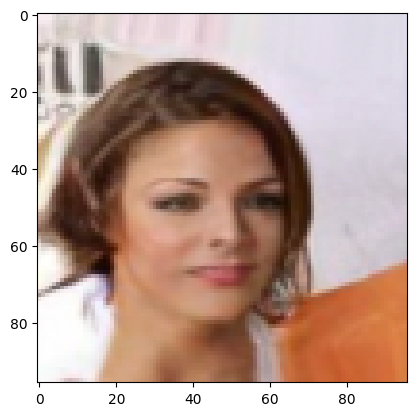

Epoch 436, Batch 1530/2544, Loss: 0.020739246159791946
Epoch 436, Batch 1780/2544, Loss: 0.014739800244569778
Epoch 436, Batch 2030/2544, Loss: 0.013537363149225712
Epoch 436, Batch 2280/2544, Loss: 0.015068303793668747
Epoch 436, Batch 2530/2544, Loss: 0.012314165011048317
Epoch 437, Batch 236/2544, Loss: 0.010683388449251652
Epoch 437, Batch 486/2544, Loss: 0.01324960682541132
Epoch 437, Batch 736/2544, Loss: 0.012751870788633823


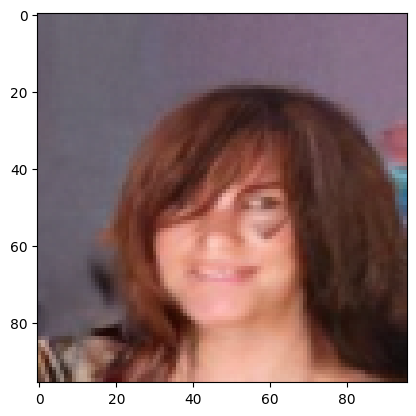

Epoch 437, Batch 986/2544, Loss: 0.011314916424453259
Epoch 437, Batch 1236/2544, Loss: 0.012715142220258713
Epoch 437, Batch 1486/2544, Loss: 0.008159617893397808
Epoch 437, Batch 1736/2544, Loss: 0.016537077724933624
Epoch 437, Batch 1986/2544, Loss: 0.014481243677437305
Epoch 437, Batch 2236/2544, Loss: 0.010504612699151039
Epoch 437, Batch 2486/2544, Loss: 0.011300325393676758
Epoch 438, Batch 192/2544, Loss: 0.010581625625491142


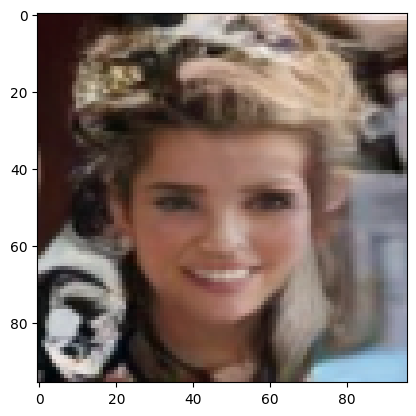

Epoch 438, Batch 442/2544, Loss: 0.017605602741241455
Epoch 438, Batch 692/2544, Loss: 0.009495293721556664
Epoch 438, Batch 942/2544, Loss: 0.012597518973052502
Epoch 438, Batch 1192/2544, Loss: 0.015268350020051003
Epoch 438, Batch 1442/2544, Loss: 0.007609775755554438
Epoch 438, Batch 1692/2544, Loss: 0.01086004450917244
Epoch 438, Batch 1942/2544, Loss: 0.010393884964287281
Epoch 438, Batch 2192/2544, Loss: 0.014040159061551094


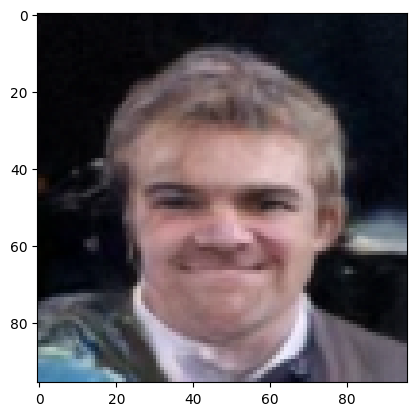

Epoch 438, Batch 2442/2544, Loss: 0.009173693135380745
Epoch 439, Batch 148/2544, Loss: 0.00854156631976366
Epoch 439, Batch 398/2544, Loss: 0.013669897802174091
Epoch 439, Batch 648/2544, Loss: 0.013238252140581608
Epoch 439, Batch 898/2544, Loss: 0.01737935096025467
Epoch 439, Batch 1148/2544, Loss: 0.013781735673546791
Epoch 439, Batch 1398/2544, Loss: 0.006697469856590033
Epoch 439, Batch 1648/2544, Loss: 0.012748581357300282


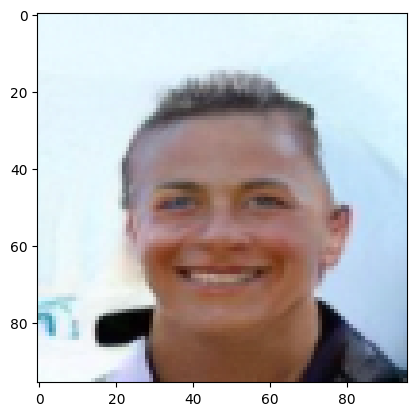

Epoch 439, Batch 1898/2544, Loss: 0.016431935131549835
Epoch 439, Batch 2148/2544, Loss: 0.013276885263621807
Epoch 439, Batch 2398/2544, Loss: 0.010390385054051876
Epoch 440, Batch 104/2544, Loss: 0.008625948801636696
Epoch 440, Batch 354/2544, Loss: 0.018502594903111458
Epoch 440, Batch 604/2544, Loss: 0.008624108508229256
Epoch 440, Batch 854/2544, Loss: 0.008367842063307762
Epoch 440, Batch 1104/2544, Loss: 0.01460943277925253


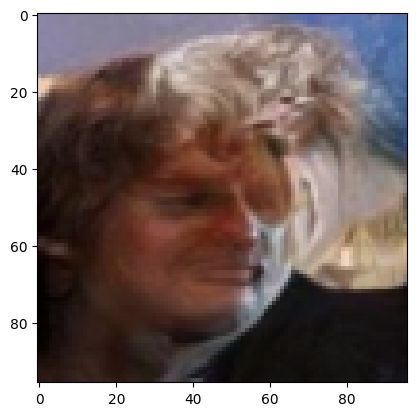

Epoch 440, Batch 1354/2544, Loss: 0.00999964214861393
Epoch 440, Batch 1604/2544, Loss: 0.007801196072250605
Epoch 440, Batch 1854/2544, Loss: 0.007834983989596367
Epoch 440, Batch 2104/2544, Loss: 0.0075708068907260895
Epoch 440, Batch 2354/2544, Loss: 0.01409032754600048
Epoch 441, Batch 60/2544, Loss: 0.010230135172605515
Epoch 441, Batch 310/2544, Loss: 0.01237222459167242
Epoch 441, Batch 560/2544, Loss: 0.012704086489975452


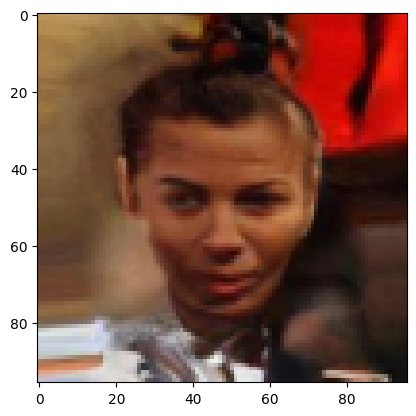

Epoch 441, Batch 810/2544, Loss: 0.01922118104994297
Epoch 441, Batch 1060/2544, Loss: 0.008750775828957558
Epoch 441, Batch 1310/2544, Loss: 0.013656549155712128
Epoch 441, Batch 1560/2544, Loss: 0.012356393970549107
Epoch 441, Batch 1810/2544, Loss: 0.010002357885241508
Epoch 441, Batch 2060/2544, Loss: 0.013294292613863945
Epoch 441, Batch 2310/2544, Loss: 0.006693507079035044
Epoch 442, Batch 16/2544, Loss: 0.009734520688652992


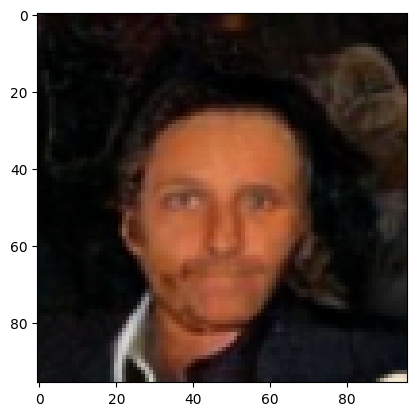

Epoch 442, Batch 266/2544, Loss: 0.015179400332272053
Epoch 442, Batch 516/2544, Loss: 0.014994044788181782
Epoch 442, Batch 766/2544, Loss: 0.017848946154117584
Epoch 442, Batch 1016/2544, Loss: 0.017583034932613373
Epoch 442, Batch 1266/2544, Loss: 0.014949403703212738
Epoch 442, Batch 1516/2544, Loss: 0.005568563938140869
Epoch 442, Batch 1766/2544, Loss: 0.019322967156767845
Epoch 442, Batch 2016/2544, Loss: 0.012136799283325672


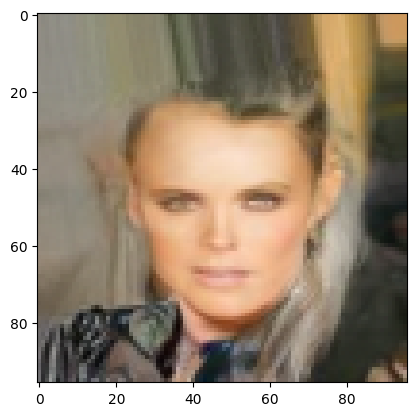

Epoch 442, Batch 2266/2544, Loss: 0.0108402194455266
Epoch 442, Batch 2516/2544, Loss: 0.007144906558096409
Epoch 443, Batch 222/2544, Loss: 0.00882848259061575
Epoch 443, Batch 472/2544, Loss: 0.007554247975349426
Epoch 443, Batch 722/2544, Loss: 0.010121442377567291
Epoch 443, Batch 972/2544, Loss: 0.015197009779512882
Epoch 443, Batch 1222/2544, Loss: 0.01378691103309393


In [ ]:
from torchvision.datasets import CIFAR10, CelebA, Flowers102

batch_size = 64
learning_rate = 4e-5
img_size = 96
epochs = 500
steps = 1000
device = 'cuda'

preprocess = transforms.Compose([
  transforms.Resize((img_size, img_size)),
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(),
])



diffusion = Diffusion(steps=steps, img_size=img_size, img_c=3, t_dim=256, device=device)
# ds = Flowers102(root='./data', download=True, transform=preprocess)
ds = CelebA(root='./data', download=True, transform=preprocess)
# ds = CIFAR10(root='./data', download=True, train=True, transform=preprocess)
diffusion.train(ds, batch_size, learning_rate, epochs)

<ipython-input-14-942163580431>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('./drive/MyDrive/diffusion2/0.pth')


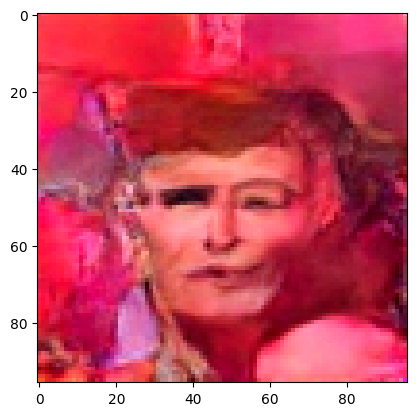

In [ ]:
batch_size = 16
learning_rate = 1e-4
img_size = 96
epochs = 500
steps = 500
device = 'cuda'

preprocess = transforms.Compose([
  transforms.Resize((img_size, img_size)),
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(),
])



diffusion = Diffusion(steps=steps, img_size=img_size, img_c=3, t_dim=256, device=device)
ckpt = torch.load('./drive/MyDrive/diffusion2/0.pth')
diffusion.unet.load_state_dict(ckpt)

diffusion.unet.eval()
img = diffusion.sample()
img = img.transpose(0, 2, 3, 1)
img = (img[0] * 255).astype(int)
plt.imshow(img)
plt.show()

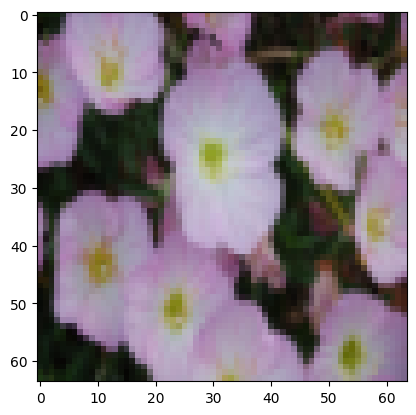

In [ ]:
preprocess = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(),
])
ds = Flowers102(root='./data', download=True, transform=preprocess)
plt.imshow(ds[0][0].numpy().transpose(1,2,0))